# Notebook to train last layer

In [1]:
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from pathlib import Path
from tqdm import tqdm
import h5py as h5
import argparse

In [2]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()

In [3]:
import matplotlib.pyplot as plt

In [4]:
import torch

/Users/billyli/miniforge_x86_new/envs/weaver/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
root_dir = Path("/Users/billyli/scope/JetClass/minimal")
list(root_dir.glob('*.root'))

[PosixPath('/Users/billyli/scope/JetClass/minimal/HToCC_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/WToQQ_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/ZToQQ_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/HToBB_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/HToGG_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/HToWW2Q1L_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/TTBarLep_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/TTBar_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/ZJetsToNuNu_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/HToWW4Q_120.root')]

In [6]:
f = list(root_dir.glob('*.root'))[0]
f.name.split('_')

['HToCC', '120.root']

## Get Jet label from Root Files

In [7]:
total_size = 1e6
data_fraction = 3e-2
val_fraction = 1e-2

In [8]:
def feature_to_numpy(tree, feature):
    return tree[feature].arrays().to_numpy().astype(float)

In [9]:
jet_classes = []
for f in root_dir.glob('*.root'):
    process = f.name.split('_')[0]
    tree = uproot.open(f)['tree']

    n_entries = tree.num_entries
    n_keep = int(n_entries * data_fraction)

    jet_label_f = tree.arrays(
        filter_name=['label_*'],
        entry_stop=n_keep,  # only read first fraction
    )

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    jet_class = np.stack([jet_label_f[n].to_numpy().astype('int') for n in label_list], axis=1)
    jet_classes.append(jet_class)
y = np.concatenate(jet_classes, axis=0)
y_tensor = torch.tensor(y)

## Load RAV

In [10]:
rav = h5.File('/Users/billyli/scope/particle_transformer/notebooks/rav_sdmass_frac_3e-2.h5', 'r')["RAV_jet_sdmass"][:]
rav_tensor = torch.tensor(rav, dtype=torch.float32)
print(rav_tensor.size())

torch.Size([128, 1])


## Find the hidden state's orthogonal component

In [11]:
hidden = h5.File("/Users/billyli/scope/weaver-core/frac_3e-2.h5", 'r')["hidden_11"][:]
hidden_tensor = torch.tensor(hidden, dtype=torch.float32)
print(hidden_tensor.size())

torch.Size([30000, 1, 128])


In [12]:
import torch

def perpendicular_component(hidden_tensor, raw_tensor, eps=1e-12):
    """
    hidden_tensor: (30000, 128, 1)  vectors v
    raw_tensor:    either (30000, 128, 1) per-sample u
                   or     (128, 1) / (128,) shared u
    returns:       (30000, 128, 1)  v_perp
    """
    v = hidden_tensor.squeeze(-1)  # (30000, 128)
    u = raw_tensor.squeeze(-1)     # (30000,128) or (128,)

    # Broadcast u to match v if needed
    if u.dim() == 1:
        u = u.unsqueeze(0).expand_as(v)  # (1,128) -> (30000,128)
    elif u.shape != v.shape:
        u = u.expand_as(v)

    # Compute projection scalar coeff alpha = (v·u)/(u·u)
    alpha = (v * u).sum(dim=-1, keepdim=True) / ((u * u).sum(dim=-1, keepdim=True) + eps)  # (30000,1)

    proj = alpha * u             # (30000,128)
    v_perp = v - proj            # (30000,128)
    return v_perp.permute(0, 2, 1)  # (30000,128,1)


In [13]:

hidden_perp = perpendicular_component(hidden_tensor, rav_tensor)

In [14]:
(hidden_perp.squeeze(-1) @ rav_tensor.squeeze(-1) > 1e-4).sum() # should be close to 0

tensor(0)

## Define the last layer

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class PerpClassifier(nn.Module):
    def __init__(self, in_dim=128, num_classes=10, for_inference=False):
        super().__init__()
        self.norm = nn.LayerNorm(in_dim)
        self.fc = nn.Linear(in_dim, num_classes)
        self.for_inference = for_inference

    def forward(self, cls_tokens, rav_tensor=None, return_hidden=False):
        """
        cls_tokens: (N, C) or (1, N, C) like your snippet
        raw_tensor: (N, C) or (C,) direction(s) to project out
        """
        # Match your snippet's first lines
        if cls_tokens.dim() == 3:
            # (1, N, C) -> (N, C)
            x_cls = self.norm(cls_tokens).squeeze(0)
        else:
            x_cls = self.norm(cls_tokens)

        # Keep track if you want
        hiddens = [x_cls.unsqueeze(0)]

        # Use perpendicular component if provided
        if rav_tensor is not None:
            x_used = perpendicular_component(x_cls, rav_tensor)   # (N, C)
        else:
            x_used = x_cls
        
        x_used = x_used.squeeze(-1)
        logits = self.fc(x_used)                         # (N, 10)

        if self.for_inference:
            probs = F.softmax(logits, dim=1)
            return (probs, hiddens) if return_hidden else probs
        else:
            return (logits, hiddens) if return_hidden else logits


In [16]:
model = PerpClassifier(in_dim=128, num_classes=10, for_inference=False)
model.train()

PerpClassifier(
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

## Import Weaver modules

In [17]:
from torch.utils.data import DataLoader
from weaver.utils.dataset import SimpleIterDataset
from weaver.train import train_load, model_setup, optim
from weaver.utils.logger import _logger, _configLogger

## Mimic Args

In [18]:
parser = argparse.ArgumentParser()
parser.add_argument('--regression-mode', action='store_true', default=False,
                    help='run in regression mode if this flag is set; otherwise run in classification mode')
parser.add_argument('-c', '--data-config', type=str,
                    help='data config YAML file')
parser.add_argument('--extra-selection', type=str, default=None,
                    help='Additional selection requirement, will modify `selection` to `(selection) & (extra)` on-the-fly')
parser.add_argument('--extra-test-selection', type=str, default=None,
                    help='Additional test-time selection requirement, will modify `test_time_selection` to `(test_time_selection) & (extra)` on-the-fly')
parser.add_argument('-i', '--data-train', nargs='*', default=[],
                    help='training files; supported syntax:'
                         ' (a) plain list, `--data-train /path/to/a/* /path/to/b/*`;'
                         ' (b) (named) groups [Recommended], `--data-train a:/path/to/a/* b:/path/to/b/*`,'
                         ' the file splitting (for each dataloader worker) will be performed per group,'
                         ' and then mixed together, to ensure a uniform mixing from all groups for each worker.'
                    )
parser.add_argument('-l', '--data-val', nargs='*', default=[],
                    help='validation files; when not set, will use training files and split by `--train-val-split`')
parser.add_argument('-t', '--data-test', nargs='*', default=[],
                    help='testing files; supported syntax:'
                         ' (a) plain list, `--data-test /path/to/a/* /path/to/b/*`;'
                         ' (b) keyword-based, `--data-test a:/path/to/a/* b:/path/to/b/*`, will produce output_a, output_b;'
                         ' (c) split output per N input files, `--data-test a%%10:/path/to/a/*`, will split per 10 input files')
parser.add_argument('--data-fraction', type=float, default=1,
                    help='fraction of events to load from each file; for training, the events are randomly selected for each epoch')
parser.add_argument('--file-fraction', type=float, default=1,
                    help='fraction of files to load; for training, the files are randomly selected for each epoch')
parser.add_argument('--fetch-by-files', action='store_true', default=False,
                    help='When enabled, will load all events from a small number (set by ``--fetch-step``) of files for each data fetching. '
                         'Otherwise (default), load a small fraction of events from all files each time, which helps reduce variations in the sample composition.')
parser.add_argument('--fetch-step', type=float, default=0.01,
                    help='fraction of events to load each time from every file (when ``--fetch-by-files`` is disabled); '
                         'Or: number of files to load each time (when ``--fetch-by-files`` is enabled). Shuffling & sampling is done within these events, so set a large enough value.')
parser.add_argument('--in-memory', action='store_true', default=False,
                    help='load the whole dataset (and perform the preprocessing) only once and keep it in memory for the entire run')
parser.add_argument('--train-val-split', type=float, default=0.8,
                    help='training/validation split fraction')
parser.add_argument('--no-remake-weights', action='store_true', default=False,
                    help='do not remake weights for sampling (reweighting), use existing ones in the previous auto-generated data config YAML file')
parser.add_argument('--demo', action='store_true', default=False,
                    help='quickly test the setup by running over only a small number of events')
parser.add_argument('--lr-finder', type=str, default=None,
                    help='run learning rate finder instead of the actual training; format: ``start_lr, end_lr, num_iters``')
parser.add_argument('--tensorboard', type=str, default=None,
                    help='create a tensorboard summary writer with the given comment')
parser.add_argument('--tensorboard-custom-fn', type=str, default=None,
                    help='the path of the python script containing a user-specified function `get_tensorboard_custom_fn`, '
                         'to display custom information per mini-batch or per epoch, during the training, validation or test.')
parser.add_argument('-n', '--network-config', type=str,
                    help='network architecture configuration file; the path must be relative to the current dir')
parser.add_argument('-o', '--network-option', nargs=2, action='append', default=[],
                    help='options to pass to the model class constructor, e.g., `--network-option use_counts False`')
parser.add_argument('-m', '--model-prefix', type=str, default='models/{auto}/network',
                    help='path to save or load the model; for training, this will be used as a prefix, so model snapshots '
                         'will saved to `{model_prefix}_epoch-%%d_state.pt` after each epoch, and the one with the best '
                         'validation metric to `{model_prefix}_best_epoch_state.pt`; for testing, this should be the full path '
                         'including the suffix, otherwise the one with the best validation metric will be used; '
                         'for training, `{auto}` can be used as part of the path to auto-generate a name, '
                         'based on the timestamp and network configuration')
parser.add_argument('--load-model-weights', type=str, default=None,
                    help='initialize model with pre-trained weights')
parser.add_argument('--exclude-model-weights', type=str, default=None,
                    help='comma-separated regex to exclude matched weights from being loaded, e.g., `a.fc..+,b.fc..+`')
parser.add_argument('--freeze-model-weights', type=str, default=None,
                    help='comma-separated regex to freeze matched weights from being updated in the training, e.g., `a.fc..+,b.fc..+`')
parser.add_argument('--num-epochs', type=int, default=20,
                    help='number of epochs')
parser.add_argument('--steps-per-epoch', type=int, default=None,
                    help='number of steps (iterations) per epochs; '
                         'if neither of `--steps-per-epoch` or `--samples-per-epoch` is set, each epoch will run over all loaded samples')
parser.add_argument('--steps-per-epoch-val', type=int, default=None,
                    help='number of steps (iterations) per epochs for validation; '
                         'if neither of `--steps-per-epoch-val` or `--samples-per-epoch-val` is set, each epoch will run over all loaded samples')
parser.add_argument('--samples-per-epoch', type=int, default=None,
                    help='number of samples per epochs; '
                         'if neither of `--steps-per-epoch` or `--samples-per-epoch` is set, each epoch will run over all loaded samples')
parser.add_argument('--samples-per-epoch-val', type=int, default=None,
                    help='number of samples per epochs for validation; '
                         'if neither of `--steps-per-epoch-val` or `--samples-per-epoch-val` is set, each epoch will run over all loaded samples')
parser.add_argument('--optimizer', type=str, default='ranger', choices=['adam', 'adamW', 'radam', 'ranger'],  # TODO: add more
                    help='optimizer for the training')
parser.add_argument('--optimizer-option', nargs=2, action='append', default=[],
                    help='options to pass to the optimizer class constructor, e.g., `--optimizer-option weight_decay 1e-4`')
parser.add_argument('--lr-scheduler', type=str, default='flat+decay',
                    choices=['none', 'steps', 'flat+decay', 'flat+linear', 'flat+cos', 'one-cycle'],
                    help='learning rate scheduler')
parser.add_argument('--warmup-steps', type=int, default=0,
                    help='number of warm-up steps, only valid for `flat+linear` and `flat+cos` lr schedulers')
parser.add_argument('--load-epoch', type=int, default=None,
                    help='used to resume interrupted training, load model and optimizer state saved in the `epoch-%%d_state.pt` and `epoch-%%d_optimizer.pt` files')
parser.add_argument('--start-lr', type=float, default=5e-3,
                    help='start learning rate')
parser.add_argument('--batch-size', type=int, default=128,
                    help='batch size')
parser.add_argument('--use-amp', action='store_true', default=False,
                    help='use mixed precision training (fp16)')
parser.add_argument('--gpus', type=str, default='0',
                    help='device for the training/testing; to use CPU, set to empty string (""); to use multiple gpu, set it as a comma separated list, e.g., `1,2,3,4`')
parser.add_argument('--predict-gpus', type=str, default=None,
                    help='device for the testing; to use CPU, set to empty string (""); to use multiple gpu, set it as a comma separated list, e.g., `1,2,3,4`; if not set, use the same as `--gpus`')
parser.add_argument('--num-workers', type=int, default=1,
                    help='number of threads to load the dataset; memory consumption and disk access load increases (~linearly) with this numbers')
parser.add_argument('--predict', action='store_true', default=False,
                    help='run prediction instead of training')
parser.add_argument('--predict-output', type=str,
                    help='path to save the prediction output, support `.root` and `.parquet` format')
parser.add_argument('--export-onnx', type=str, default=None,
                    help='export the PyTorch model to ONNX model and save it at the given path (path must ends w/ .onnx); '
                         'needs to set `--data-config`, `--network-config`, and `--model-prefix` (requires the full model path)')
parser.add_argument('--onnx-opset', type=int, default=15,
                    help='ONNX opset version.')
parser.add_argument('--io-test', action='store_true', default=False,
                    help='test throughput of the dataloader')
parser.add_argument('--copy-inputs', action='store_true', default=False,
                    help='copy input files to the current dir (can help to speed up dataloading when running over remote files, e.g., from EOS)')
parser.add_argument('--log', type=str, default='',
                    help='path to the log file; `{auto}` can be used as part of the path to auto-generate a name, based on the timestamp and network configuration')
parser.add_argument('--print', action='store_true', default=False,
                    help='do not run training/prediction but only print model information, e.g., FLOPs and number of parameters of a model')
parser.add_argument('--profile', action='store_true', default=False,
                    help='run the profiler')
parser.add_argument('--backend', type=str, choices=['gloo', 'nccl', 'mpi'], default=None,
                    help='backend for distributed training')
parser.add_argument('--cross-validation', type=str, default=None,
                    help='enable k-fold cross validation; input format: `variable_name%%k`')
parser.add_argument('--disable-mps', action='store_true', default=False,
                    help='disable using mps device if it does not work for you')
parser.add_argument('--hidden-states-out', type=str, default="hidden_states_out.h5",
                    help='path to save hidden states as h5 file')
parser.add_argument('--hidden-states', action='store_true', default=False,
                    help='let ParT output hidden states with the logits')

_StoreTrueAction(option_strings=['--hidden-states'], dest='hidden_states', nargs=0, const=True, default=False, type=None, choices=None, help='let ParT output hidden states with the logits', metavar=None)

In [19]:
args = parser.parse_args([
    "--predict",
    "--data-test", "/Users/billyli/scope/JetClass/minimal/*.root",
    "--data-config", "/Users/billyli/scope/particle_transformer/data/JetClass/JetClass_full.yaml",
    "--data-fraction", f"{data_fraction}",
    "--network-config", "/Users/billyli/scope/particle_transformer/networks/ParT_w_hidden_states.py",
    "--use-amp",
    "--model-prefix", "/Users/billyli/scope/particle_transformer/models/ParT_full.pt",
    "--batch-size", "64",
    "--predict-output", "/Users/billyli/scope/particle_transformer/tmp/test_output.root",
    "--gpus", "",
    "--num-workers", "0",
    "--disable-mps",
    "--hidden-states"
])

## Deivice

In [20]:
# device
if args.gpus:
    # distributed training
    if args.backend is not None:
        local_rank = args.local_rank
        torch.cuda.set_device(local_rank)
        gpus = [local_rank]
        dev = torch.device(local_rank)
        torch.distributed.init_process_group(backend=args.backend)
        _logger.info(f'Using distributed PyTorch with {args.backend} backend')
    else:
        gpus = [int(i) for i in args.gpus.split(',')]
        dev = torch.device(gpus[0])
else:
    gpus = None
    dev = torch.device('cpu')
    if not args.disable_mps:
        try:
            if torch.backends.mps.is_available():
                dev = torch.device('mps')
        except AttributeError:
            pass

In [21]:
args.local_rank = None if args.backend is None else int(os.environ.get("LOCAL_RANK", "0"))

## Prepare Dataloader for training

In [22]:
from torch.utils.data import TensorDataset, DataLoader, random_split

In [23]:
# Example: X: (N, 128), y_onehot: (N, 10)
y_idx = y_tensor.argmax(dim=1).long()  # (N,)

# Wrap into a dataset
dataset = TensorDataset(hidden_tensor, y_idx)

# Split 9:1
N = len(dataset)
n_train = int(0.9 * N)
n_val   = N - n_train
train_set, val_set = random_split(dataset, [n_train, n_val])

# Build DataLoaders
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=args.batch_size, shuffle=False)


## Config Optim

In [24]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

## Loss

In [25]:
criterion = nn.CrossEntropyLoss()

## Train the last layer

In [26]:
epoch = 2

In [27]:
@torch.no_grad()
def eval_epoch(loader, rav_tensor, device='cpu'):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb, rav_tensor=rav_tensor)
        loss = criterion(logits, yb)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        total_loss += loss.item() * yb.size(0)
    return total_loss/total, correct/total

In [28]:
eppoch = 2

In [29]:
for epoch in range(1, 1000):
    model.train()
    total, correct, total_loss = 0, 0, 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(dev), yb.to(dev)
        xb.permute(1, 0, 2)
        opt.zero_grad(set_to_none=True)
        logits = model(xb, rav_tensor=rav_tensor)   # logits from perp(x)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()

        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        total_loss += loss.item() * yb.size(0)

    train_loss = total_loss/total
    train_acc = correct/total
    val_loss, val_acc = eval_epoch(train_loader, rav_tensor)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

Epoch 01 | train loss 1.9288 acc 0.3576 | val loss 1.4760 acc 0.6284
Epoch 02 | train loss 1.1843 acc 0.7583 | val loss 0.9501 acc 0.8138
Epoch 03 | train loss 0.8074 acc 0.8286 | val loss 0.6951 acc 0.8384
Epoch 04 | train loss 0.6273 acc 0.8420 | val loss 0.5728 acc 0.8453
Epoch 05 | train loss 0.5383 acc 0.8479 | val loss 0.5096 acc 0.8503
Epoch 06 | train loss 0.4906 acc 0.8515 | val loss 0.4741 acc 0.8526
Epoch 07 | train loss 0.4630 acc 0.8533 | val loss 0.4529 acc 0.8539
Epoch 08 | train loss 0.4462 acc 0.8541 | val loss 0.4397 acc 0.8549
Epoch 09 | train loss 0.4354 acc 0.8553 | val loss 0.4310 acc 0.8554
Epoch 10 | train loss 0.4282 acc 0.8555 | val loss 0.4251 acc 0.8558
Epoch 11 | train loss 0.4233 acc 0.8564 | val loss 0.4210 acc 0.8563
Epoch 12 | train loss 0.4199 acc 0.8564 | val loss 0.4180 acc 0.8564
Epoch 13 | train loss 0.4173 acc 0.8563 | val loss 0.4158 acc 0.8561
Epoch 14 | train loss 0.4154 acc 0.8568 | val loss 0.4141 acc 0.8574
Epoch 15 | train loss 0.4138 acc 0

## Evaluate training mass scultping

In [51]:
qcd_sdmass = []
for f in root_dir.glob('ZJetsToNuNu_*.root'):
    process = f.name.split('_')[0]
    tree = uproot.open(f)['tree']

    n_entries = tree.num_entries
    n_keep = int(n_entries * data_fraction)
    qcd_sdmass_f = tree.arrays(
        filter_name=['jet_sdmass'],
        entry_stop=n_keep,  # only read first fraction
        library='np',
    )
    qcd_sdmass.append(qcd_sdmass_f['jet_sdmass'])
qcd_sdmass = np.concatenate(qcd_sdmass, axis=0)

In [37]:
list(root_dir.glob('*.root'))

[PosixPath('/Users/billyli/scope/JetClass/minimal/HToCC_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/WToQQ_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/ZToQQ_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/HToBB_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/HToGG_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/HToWW2Q1L_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/TTBarLep_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/TTBar_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/ZJetsToNuNu_120.root'),
 PosixPath('/Users/billyli/scope/JetClass/minimal/HToWW4Q_120.root')]

In [40]:
n_tot = hidden_tensor.size()[0]
n_qcd_size = int(n_tot/10)
n_qcd_start = int(n_tot/10*8)
n_qcd_end = n_qcd_start + n_qcd_size
hidden_qcd = hidden_tensor[n_qcd_start:n_qcd_end, :, :]

In [49]:
model.eval()
model.for_inference = True
scores = model(hidden_qcd.to(dev), rav_tensor=rav_tensor.to(dev))
Xbb = scores[:, 1]
QCD = scores[:, 0]
XbbvsQCD = Xbb / (Xbb + QCD)

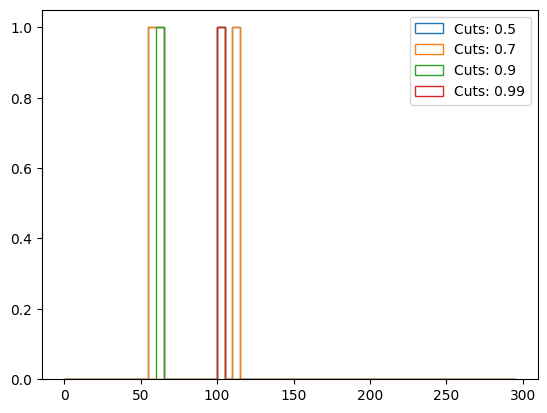

In [73]:
cut = [0.5, 0.7, 0.9, 0.99]
fig, ax = plt.subplots()
for c in cut:
    ax.hist(qcd_sdmass[XbbvsQCD > c], label=f"Cuts: {c}", bins=np.arange(0, 300, 5), histtype='step')
ax.legend()

In [71]:
qcd_sdmass[XbbvsQCD > 0.99].size

1